# Data Cleaning

All of the data below was found on the [Where Workers Work](https://ides.illinois.gov/resources/labor-market-information/where-workers-work.html) report, released yearly by the Illinois Department of Unemployment Security (IDES). This report shows the private sector employment totals divided by NAICS industry type for the 6 counties of the metro Chicago area (Cook, DuPage, Kane, Lake, McHenry, and Will). It also divides further into the neighborhoods and associated ZIP codes for the city of Chicago. Note that this data does not account for any public sector employees. Additionally, certain data points are not published by IDES to avoid disclosure of individual data. This process is automated and takes effect if:

1) There are less than 3 establishments in a specific industry for a geographic region; or \
2) One establishment accounts for at least 80% of the total employment in an industry within a geographic region.

For the purposes of this project, we are only interested in the total numbers of jobs per ZIP code, so we used the following publications: \
2001-2019 Data (Tables 17-32):
https://ides.illinois.gov/content/dam/soi/en/web/ides/labor_market_information/where_workers_work/2020.zip \
2020 Data: https://ides.illinois.gov/content/dam/soi/en/web/ides/labor_market_information/where_workers_work/2020q3.xls

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Reading in 2001-2019 job data

In [2]:
'''
jobs_2 (Outer Business Ring sheet) can't be read in as an integers because
there are null values. This is because before 2002, 60606 and 60661 were grouped
together. There's an extra column that reflects this
''';

jobs_1 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 25',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,E,G,I,K')
jobs_2 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 26',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       usecols='A,E,G,I,K,M,O,Q',
                       na_values=0)
jobs_3 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 27',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,C:M')
jobs_4 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 28',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,C:J')
jobs_5 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 29',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,E,G,I,K,M')
jobs_6 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 30',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,C:J,L')
jobs_7 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 31',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,C:K')
jobs_8 = pd.read_excel('./datasets/2020q1/2020TAB17-32.xls', sheet_name='Table 32',
                       index_col=0,
                       header=5,
                       skiprows=[6],
                       nrows=19,
                       dtype=int,
                       usecols='A,D,F,H,J,L')

### Fixing Missing Values for jobs_2

I don't want to drop these observations since the 60606 and 60611 ZIP codes (located in the central business district) account for more than 10% of all the jobs in Chicago. \
I am going to operate under the assumption that the proportion of jobs in 60606 and 60611 in relation to one another either remained the same or changed in a predictable mattern. I'm going to attempt to predict the proportion of jobs in 2001 that were in 60611 vs. 60606 and then apply that to the total number of jobs in both ZIP codes combined (125,029).

In [3]:
jobs_2

60606 & 60661 **  60606 **  60661 **  60611  60610 & 54  60607  60605
2001          125029.0       NaN       NaN  82000       59460  29422  21788
2002               NaN  103682.0   19161.0  77330       55345  30414  20980
2003               NaN   98382.0   19913.0  76790       53258  29534  20255
2004               NaN   97559.0   19990.0  75114       53614  28939  19506
2005               NaN   95226.0   20934.0  79849       52900  27960  19962
2006               NaN   98282.0   20529.0  80359       55593  31318  21602
2007               NaN  102092.0   22079.0  82215       58350  30770  22132
2008               NaN  107029.0   22219.0  87351       59842  30697  21798
2009               NaN  104346.0   21929.0  77685       59251  28018  21355
2010               NaN  104842.0   22058.0  73464       61463  26788  20470
2011               NaN  109370.0   22929.0  73054       62616  30084  19785
2012               NaN  114447.0   24028.0  75570       70146  31292  18141
2013               NaN  115994.0   25520.0  76664       70900  33695  18733
2014               NaN  119536.0   26763.0  78060       72756  34803  19315
2015               NaN  122580.0   29436.0  79757       77894  37775  19212
2016               NaN  127854.0   31235.0  81485       80633  39096  19075
2017               NaN  131778.0   30186.0  91535       80054  43746  18771
2018               NaN  137518.0   31069.0  91702       84175  47996  18531
2019               NaN  139075.0   32151.0  92449       86392  48948  18216

In [4]:
jobs_2.rename({'60606 & 60661 **': 'combined',
               '60606 **'        : '60606',
               '60661 **'        : '60661'},
              axis=1, inplace=True)

In [5]:
jobs_2['percentage_60661'] = jobs_2['60661'] / (jobs_2['60606'] + jobs_2['60661'])

In [6]:
null_model = jobs_2['percentage_60661'].mean()
null_model

0.17794922053763781

In [7]:
X = np.array(jobs_2.index[1:]).reshape(-1,1)

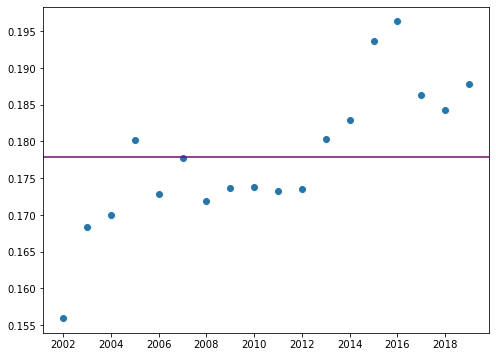

In [8]:
plt.figure(figsize=(8,6))
plt.xticks(X[::2])
plt.axhline(null_model, color='purple')
plt.scatter(jobs_2.index, jobs_2['percentage_60661']);

These values are clearly not normally distributed. Rather, they seem to have a linerally ascending pattern.

In [9]:
X = np.array(jobs_2.index[1:]).reshape(-1,1)

In [10]:
y = jobs_2['percentage_60661'][1:]

In [11]:
# baseline score:
mean_squared_error(y, np.repeat(null_model, len(y)), squared=False)

0.009441812203980183

In [12]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [13]:
y_pred=lr.predict(X)

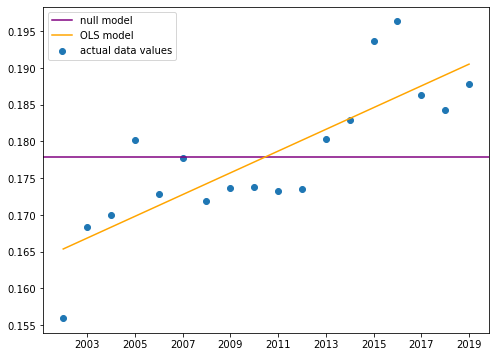

In [14]:
plt.figure(figsize=(8,6))
plt.xticks(jobs_2.index[::2])
plt.axhline(null_model, color='purple', label='null model')
plt.scatter(X, y, label='actual data values')
plt.plot(X, y_pred, color = 'orange', label='OLS model')
plt.legend();

The linear model is clearly a much better fit to the data.

In [15]:
mean_squared_error(y, y_pred, squared=False)

0.005495858544258656

This nearly halved the RMSE of the baseline, so this model should suffice.

In [16]:
# imputing the missing values based on our predicted proportion
jobs_2.loc[2001, 'percentage_60661'] = lr.predict(np.array(2001).reshape(-1,1))[0]
jobs_2.loc[2001, '60661'] = round(jobs_2.loc[2001, 'percentage_60661'] * jobs_2.loc[2001, 'combined'])
jobs_2.loc[2001, '60606'] = jobs_2.loc[2001, 'combined'] - jobs_2.loc[2001, '60661']

In [17]:
jobs_2

combined     60606    60661  60611  60610 & 54  60607  60605  \
2001  125029.0  104538.0  20491.0  82000       59460  29422  21788   
2002       NaN  103682.0  19161.0  77330       55345  30414  20980   
2003       NaN   98382.0  19913.0  76790       53258  29534  20255   
2004       NaN   97559.0  19990.0  75114       53614  28939  19506   
2005       NaN   95226.0  20934.0  79849       52900  27960  19962   
2006       NaN   98282.0  20529.0  80359       55593  31318  21602   
2007       NaN  102092.0  22079.0  82215       58350  30770  22132   
2008       NaN  107029.0  22219.0  87351       59842  30697  21798   
2009       NaN  104346.0  21929.0  77685       59251  28018  21355   
2010       NaN  104842.0  22058.0  73464       61463  26788  20470   
2011       NaN  109370.0  22929.0  73054       62616  30084  19785   
2012       NaN  114447.0  24028.0  75570       70146  31292  18141   
2013       NaN  115994.0  25520.0  76664       70900  33695  18733   
2014       NaN  119536.0  26763.0  78060       72756  34803  19315   
2015       NaN  122580.0  29436.0  79757       77894  37775  19212   
2016       NaN  127854.0  31235.0  81485       80633  39096  19075   
2017       NaN  131778.0  30186.0  91535       80054  43746  18771   
2018       NaN  137518.0  31069.0  91702       84175  47996  18531   
2019       NaN  139075.0  32151.0  92449       86392  48948  18216   

      percentage_60661  
2001          0.163891  
2002          0.155980  
2003          0.168333  
2004          0.170057  
2005          0.180217  
2006          0.172787  
2007          0.177811  
2008          0.171910  
2009          0.173661  
2010          0.173822  
2011          0.173312  
2012          0.173519  
2013          0.180336  
2014          0.182934  
2015          0.193638  
2016          0.196337  
2017          0.186375  
2018          0.184291  
2019          0.187769

In [18]:
jobs_2.drop(columns = ['combined', 'percentage_60661'], inplace=True)
jobs_2 = jobs_2.astype(int)
jobs_2.rename({'60606': 60606, '60661': 60661}, axis=1, inplace=True)

## Reading in 2020 job data

In [19]:
job2020_1 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table9',
                         header=5,
                         nrows=1,
                         usecols='E,G,I,K')
job2020_2 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table10',
                         header=5,
                         nrows=1,
                         usecols='E,G,I,K,M,O')
job2020_3 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table11',
                         header=5,
                         nrows=1,
                         usecols='C,D,E,F,G,H,I,J,K,L,M')
job2020_4 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table12',
                         header=5,
                         nrows=1,
                         usecols='C,D,E,F,G,H,I,J')
job2020_5 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table13',
                         header=5,
                         nrows=1,
                         usecols='E,G,I,K,M')
job2020_6 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table14',
                         header=5,
                         nrows=1,
                         usecols='C,D,E,F,G,H,I,J,K')
job2020_7 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table15',
                         header=5,
                         nrows=1,
                         usecols='C,D,E,F,G,H,I,J,K')
job2020_8 = pd.read_excel('./datasets/2020q3_where_workers_work.xls', sheet_name='Table16',
                         header=5,
                         nrows=1,
                         usecols='D,F,H,J,L')

In [20]:
# combining 2001-2019 data with 2020 data
jobs_past_list = [jobs_2, jobs_3, jobs_4, jobs_5, jobs_6, jobs_7, jobs_8]
jobs_past = jobs_1.join(jobs_past_list)
jobs_2020_list = [job2020_2, job2020_3, job2020_4, job2020_5, job2020_6, job2020_7, job2020_8]
jobs_2020 = job2020_1.join(jobs_2020_list)
#jobs_2020['zip_code'].replace({"O'HARE":60666}, inplace=True)
jobs_2020.rename(index={0:2020}, inplace=True)

In [21]:
jobs = jobs_past.append(jobs_2020)

In [22]:
jobs

60603  60604  60601  60602   60606  60661  60611  60610 & 54  60607  \
2001  80414  36592  66738  26707  104538  20491  82000       59460  29422   
2002  73337  34949  65462  25206  103682  19161  77330       55345  30414   
2003  63823  34196  63153  25762   98382  19913  76790       53258  29534   
2004  58611  34840  66921  26781   97559  19990  75114       53614  28939   
2005  56253  34276  67929  27799   95226  20934  79849       52900  27960   
2006  59654  35651  68460  27973   98282  20529  80359       55593  31318   
2007  52623  36227  71784  28554  102092  22079  82215       58350  30770   
2008  53560  36945  73067  27901  107029  22219  87351       59842  30697   
2009  51106  38336  70006  25922  104346  21929  77685       59251  28018   
2010  48648  31807  65255  24404  104842  22058  73464       61463  26788   
2011  44892  32033  67408  24886  109370  22929  73054       62616  30084   
2012  45298  38955  70030  25626  114447  24028  75570       70146  31292   
2013  47030  40200  72338  25749  115994  25520  76664       70900  33695   
2014  47960  41406  74611  26542  119536  26763  78060       72756  34803   
2015  47919  41298  82440  25380  122580  29436  79757       77894  37775   
2016  50769  36094  81116  26860  127854  31235  81485       80633  39096   
2017  52965  36383  81696  26551  131778  30186  91535       80054  43746   
2018  55287  38936  80996  26704  137518  31069  91702       84175  47996   
2019  56667  36249  83381  26463  139075  32151  92449       86392  48948   
2020  48989  36506  78966  24549  130448  30515  81389       75995  43036   

      60605  ...  60619  60633  60649  60655  60627  60632  60623  60629  \
2001  21788  ...   5731   5235   4772   3495    580  27746  12688  11693   
2002  20980  ...   6420   4880   4898   3895    485  26456  12113  11347   
2003  20255  ...   6239   4671   4874   3639    565  26861  13514  11370   
2004  19506  ...   6525   5242   4780   3710    538  25576  12698   9675   
2005  19962  ...   6274   6377   5252   3823    539  25548  12616   9449   
2006  21602  ...   7084   5277   5199   3680    520  25551  13238   9073   
2007  22132  ...   6724   4399   5392   3745    493  25627  13659   9264   
2008  21798  ...   6428   4568   5353   3980    240  23793  13083   8546   
2009  21355  ...   6409   3418   5520   3864     93  21592  12116   8291   
2010  20470  ...   6170   3632   5293   3460     47  20767  11441   8026   
2011  19785  ...   6466   4725   5207   3546     50  21499  11542   7787   
2012  18141  ...   6508   6075   5103   3459     24  21663  12201   7807   
2013  18733  ...   6524   6769   4974   3311     20  21221  12641   6349   
2014  19315  ...   6491   7300   4482   3302     13  22747  11009   6447   
2015  19212  ...   6542   7251   4237   3347     10  22473  11020   6560   
2016  19075  ...   6508   7626   4198   3291      8  22569  11398   6875   
2017  18771  ...   5946   7611   4065   3225      6  22832  10983   7057   
2018  18531  ...   5551   7475   4149   3240     10  23724  11178   7267   
2019  18216  ...   5572   7498   3992   3286     43  24863  10810   7235   
2020  14188  ...   4674   8735   3957   3247      2  22711  10228   7035   

      60638  60652  
2001  21771   8862  
2002  19414   7668  
2003  20061   7080  
2004  20042   7023  
2005  20429   6995  
2006  21423   6757  
2007  20800   7250  
2008  20241   7190  
2009  19427   6993  
2010  19128   6628  
2011  19016   6971  
2012  18889   7185  
2013  18877   7338  
2014  19365   6436  
2015  20621   6250  
2016  20795   6405  
2017  21428   6424  
2018  21376   5871  
2019  22423   5665  
2020  19628   5123  

[20 rows x 57 columns]

## Cleaning up this dataframe to match with our GeoJson that's coming up

In [23]:
import json

In [24]:
jobs.rename({"O'HARE": 60666}, axis=1, inplace=True)

In [25]:
jobs.columns

Index([       60603,        60604,        60601,        60602,        60606,
              60661,        60611, '60610 & 54',        60607,        60605,
              60614,        60618,        60647,        60640,        60645,
              60659,        60626,        60660,        60657,        60625,
              60613,        60609,        60608,        60616,        60636,
              60621,        60637,        60615,        60653,        60624,
              60622,        60612,        60644,        60651,        60639,
              60641,        60630,        60646,        60635,        60631,
              60634,        60656,        60666,        60617,        60628,
              60643,        60620,        60619,        60633,        60649,
              60655,        60627,        60632,        60623,        60629,
              60638,        60652],
      dtype='object')

In [26]:
with open('./datasets/zip_codes.geojson') as f:
    zips_map = json.load(f)

The ZIP codes from the `jobs` dataframe and the `zips_map` json file should match. Below are the ones that don't.

In [27]:
geojson_zips = sorted([int(zips_map['features'][i]['properties']['zip']) for i in range(len(zips_map['features']))])
job_data_zips = list(jobs.columns)
set(geojson_zips) ^ set(job_data_zips)

{60610, '60610 & 54', 60627, 60635, 60642, 60654, 60707, 60827}

Note: There are two Riverdales. One is a neighborhood of Chicago which at one point had ZIP code 60627 and another is a town (separate from Chicago) with the zip code 60827. These border one another.

In [28]:
'''
getting rid of Riverdale (town, 60827) and Elmwood Park (60707)
from zips_map since they're not part of Chicago
'''

for i in range(58):
    if zips_map['features'][i]['properties']['zip'] == '60707':
        del zips_map['features'][i]
    elif zips_map['features'][i]['properties']['zip'] == '60827':
        del zips_map['features'][i]

In [29]:
geojson_zips = sorted([int(zips_map['features'][i]['properties']['zip']) for i in range(len(zips_map['features']))])
job_data_zips = list(jobs.columns)
set(geojson_zips) ^ set(job_data_zips)

{60610, '60610 & 54', 60627, 60635, 60642, 60654}

In [30]:
'''
Dropping Elmwood Park (60635) from the jobs dataframe because it's not part of Chicago.
Dropping Riverdale (neighborhood, 60627) because this is no longer
a valid zip code. Also because there was nearly no job data on this neighborhood.
Based on reading through the data description for jobs, it seems that this data was 
split between 60628 (next to former 60627) and the town of Riverdale (60827).
'''
jobs.drop(columns = [60635, 60627], inplace = True)

In [31]:
jobs

60603  60604  60601  60602   60606  60661  60611  60610 & 54  60607  \
2001  80414  36592  66738  26707  104538  20491  82000       59460  29422   
2002  73337  34949  65462  25206  103682  19161  77330       55345  30414   
2003  63823  34196  63153  25762   98382  19913  76790       53258  29534   
2004  58611  34840  66921  26781   97559  19990  75114       53614  28939   
2005  56253  34276  67929  27799   95226  20934  79849       52900  27960   
2006  59654  35651  68460  27973   98282  20529  80359       55593  31318   
2007  52623  36227  71784  28554  102092  22079  82215       58350  30770   
2008  53560  36945  73067  27901  107029  22219  87351       59842  30697   
2009  51106  38336  70006  25922  104346  21929  77685       59251  28018   
2010  48648  31807  65255  24404  104842  22058  73464       61463  26788   
2011  44892  32033  67408  24886  109370  22929  73054       62616  30084   
2012  45298  38955  70030  25626  114447  24028  75570       70146  31292   
2013  47030  40200  72338  25749  115994  25520  76664       70900  33695   
2014  47960  41406  74611  26542  119536  26763  78060       72756  34803   
2015  47919  41298  82440  25380  122580  29436  79757       77894  37775   
2016  50769  36094  81116  26860  127854  31235  81485       80633  39096   
2017  52965  36383  81696  26551  131778  30186  91535       80054  43746   
2018  55287  38936  80996  26704  137518  31069  91702       84175  47996   
2019  56667  36249  83381  26463  139075  32151  92449       86392  48948   
2020  48989  36506  78966  24549  130448  30515  81389       75995  43036   

      60605  ...  60620  60619  60633  60649  60655  60632  60623  60629  \
2001  21788  ...   8642   5731   5235   4772   3495  27746  12688  11693   
2002  20980  ...   7371   6420   4880   4898   3895  26456  12113  11347   
2003  20255  ...   7347   6239   4671   4874   3639  26861  13514  11370   
2004  19506  ...   7378   6525   5242   4780   3710  25576  12698   9675   
2005  19962  ...   7205   6274   6377   5252   3823  25548  12616   9449   
2006  21602  ...   7256   7084   5277   5199   3680  25551  13238   9073   
2007  22132  ...   6570   6724   4399   5392   3745  25627  13659   9264   
2008  21798  ...   6547   6428   4568   5353   3980  23793  13083   8546   
2009  21355  ...   6392   6409   3418   5520   3864  21592  12116   8291   
2010  20470  ...   6272   6170   3632   5293   3460  20767  11441   8026   
2011  19785  ...   6022   6466   4725   5207   3546  21499  11542   7787   
2012  18141  ...   6712   6508   6075   5103   3459  21663  12201   7807   
2013  18733  ...   6507   6524   6769   4974   3311  21221  12641   6349   
2014  19315  ...   6382   6491   7300   4482   3302  22747  11009   6447   
2015  19212  ...   6551   6542   7251   4237   3347  22473  11020   6560   
2016  19075  ...   6130   6508   7626   4198   3291  22569  11398   6875   
2017  18771  ...   6317   5946   7611   4065   3225  22832  10983   7057   
2018  18531  ...   6192   5551   7475   4149   3240  23724  11178   7267   
2019  18216  ...   6498   5572   7498   3992   3286  24863  10810   7235   
2020  14188  ...   5989   4674   8735   3957   3247  22711  10228   7035   

      60638  60652  
2001  21771   8862  
2002  19414   7668  
2003  20061   7080  
2004  20042   7023  
2005  20429   6995  
2006  21423   6757  
2007  20800   7250  
2008  20241   7190  
2009  19427   6993  
2010  19128   6628  
2011  19016   6971  
2012  18889   7185  
2013  18877   7338  
2014  19365   6436  
2015  20621   6250  
2016  20795   6405  
2017  21428   6424  
2018  21376   5871  
2019  22423   5665  
2020  19628   5123  

[20 rows x 55 columns]

In [32]:
geojson_zips = sorted([int(zips_map['features'][i]['properties']['zip']) for i in range(len(zips_map['features']))])
job_data_zips = list(jobs.columns)
set(geojson_zips) ^ set(job_data_zips)

{60610, '60610 & 54', 60642, 60654}

The above are things that I'm going to have to fix within the GeoJson. That's a tomorrow problem.